Try to memory a few number patterns with Hopfield model

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
num_size = 20
shape = [num_size, num_size]
intf_lvl = 0.01 #interference level
sat = num_size #saturation level
decay_rate = 0.01 # decay_rate
N_patterns = 5 # number of pattern in one sequence
N_trial = 100 # number of trials
dt = 1

In [4]:
def int2pattern(index):
    return [int(x) for x in bin(index).lstrip('0b').zfill(num_size+2)[2:]]
def pattern2int(pattern):
    return int("".join(str(x) for x in pattern[0]),2)

In [5]:
# generate one pattern, one number, [0,0,...,1,0,...0]
def gen_one_pattern():
    index = np.random.randint(np.power(2,num_size))
    # pattern = np.zeros(num_size)
    # pattern[index] = 1
    pattern = int2pattern(index)
    return pattern, index

http://wikiofscience.wikidot.com/science:short-term-memory#toc6

Decay theory: depending on the length of interval

o After 3 seconds = 80%

o After 6 seconds = 50%

o After 18 seconds = less than 10%

Interferency theory: determined by the number of interfering items


https://www.nature.com/articles/icb199857.pdf

Saturation: the proportion of opened channels is determined by the kinetic properties of the receptor-channel complex.

In [6]:
# time decay
# decay_rate = 0.01 # decay_rate
def decay(W, num_pattern, ifdec = True):
    t = num_pattern * dt
    if ifdec == False:
        return W
    #dec = np.sign(np.random.binomial(t, 1-decay_rate, size = shape)) # time decay results to errors
    #W = W * dec
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            if np.random.rand(1)<(decay_rate*t):
                W[ii,jj] = 0 #if W[ii,jj]>0.35*num_pattern else 0.7*num_pattern
    return W

In [7]:
# interference W
# intf_lvl = 0.01
def interference(W, num_pattern, ifint = True):
    if ifint == False:
        return W
    #intf = np.sign(np.random.binomial(num_pattern, 1-intf_lvl, size = shape)) # sequence interferency results to errors
    #W = W * intf
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            if np.random.rand(1)<(intf_lvl*num_pattern):
                W[ii,jj] = 0 #if W[ii,jj]>0.35*num_pattern else 0.7*num_pattern
    return W

In [8]:
# Rehearsal effect W
# eta_rehear = 0.1
def rehearsal(W, Patterns, ifreh = True):
    if ifreh == False or len(Patterns) <= 0:
        return W
    else:
        Patterns = np.asarray(Patterns).reshape(len(Patterns), num_size)
        Patterns_rehearsal = Patterns.dot(W)
        # Patterns_rehearsal = Patterns
        # W = W + (Patterns_rehearsal.T).dot(Patterns_rehearsal)*eta_rehear
        W = W + (Patterns_rehearsal.T).dot(Patterns)*eta_rehear
        return W#/(1+eta_rehear)**2

In [9]:
# updata W bc saturation and add pattern
#sat = 1
def update_W(W, Delta_W, pattern, ifsat = True):
    if ifsat == False:
        temp_activ = np.ones(shape)
    else:
        temp_activ = np.ones(shape)*sat-Delta_W # saturation level - last increment = ratio of activating channel
        temp_activ = (temp_activ + np.abs(temp_activ))/2
    pattern = np.asarray([pattern])
    Delta_W = temp_activ/sat * (pattern.T).dot(pattern)
    W = W + Delta_W
    return W, Delta_W

In [14]:
# accuracy
def accuracy(W, Patterns):
    acc = np.zeros(len(Patterns))
    Patterns_pre =[]
    index_pre = []
    for kk in range(len(Patterns)):
        pattern = Patterns[kk]
        pattern = np.asarray([pattern])
        for _ in range(10):
            pattern_temp = np.heaviside((pattern).dot(W.T),0.5)
            pattern = pattern_temp
        if np.abs(pattern_temp[0].max()) >0:
            pattern_temp[0] = pattern_temp[0]/np.abs(pattern_temp[0].max())
        pattern_pre = np.asarray([[1 if x> 0.5 else 0 for x in pattern_temp[0]]])
        Patterns_pre.append(pattern_pre)
        index_pre.append(pattern2int(pattern_pre))
        #if pattern2int(pattern_pre) == pattern2int(pattern):
        #    acc[kk] = 1
        acc[kk] =1 - np.sum(np.abs(np.asarray(pattern_pre)-np.asarray(pattern))) /num_size
    return acc, Patterns_pre, index_pre

In [15]:
#N_patterns = 6 # number of pattern in one sequence
def STM_trial(ifdec=True, ifint=True, ifsat=True, ifreh=True):
    Patterns = []
    Indexs = []
    Delta_W = np.zeros(shape=shape)
    W = np.zeros(shape=shape)
    for kk in range(N_patterns):
        pattern, index = gen_one_pattern() # generate new pattern
        
        
        W = rehearsal(W, Patterns, ifreh) # rehearsal effect, repeat the memorized information
        W = decay(W, len(Patterns), ifdec) # time decay, error occurs
        W = interference(W, len(Patterns), ifint) # interference, error occurs
        
        
        W, Delta_W = update_W(W, Delta_W, pattern, ifsat) # memory new pattern, update W, considering saturation
        Patterns.append(pattern)
        Indexs.append(index)
    #print(W.mean())
    W = W/num_size
    acc, Patterns_pre, index_pre = accuracy(W, Patterns)
    return Patterns, Indexs, acc, Patterns_pre, index_pre

In [12]:
num_size = 20
shape = [num_size, num_size]
intf_lvl = 0.01 # interference level
sat = 1 # saturation level
decay_rate = 0.01 # decay_rate
eta_rehear = 1e-2 # rehearsal effeciency
N_patterns = 8 # number of pattern in one sequence
N_trial = 1000 # number of trials
dt = 1

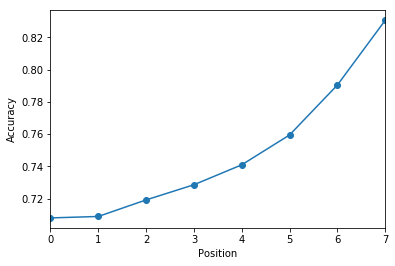

In [12]:
#N_trial = 1000 # number of trials
accs = np.zeros(N_patterns)
for _ in range(N_trial):
    Patterns, Indexs, acc, Patterns_pre, index_pre = STM_trial(ifdec=True, ifint=True, ifsat=False, ifreh=False)
    accs = accs + acc

f1 = plt.figure()
plt.plot(accs/N_trial, marker = 'o')
plt.xlim([0, N_patterns-1])
plt.ylabel("Accuracy")
plt.xlabel("Position")
plt.show(f1)

$\uparrow$ only consider about the interference and decay effect

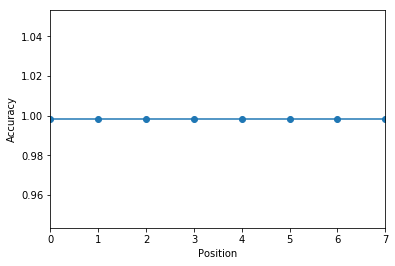

In [16]:
#N_trial = 1000 # number of trials
accs = np.zeros(N_patterns)
for _ in range(N_trial):
    Patterns, Indexs, acc, Patterns_pre, index_pre = STM_trial(ifdec=True, ifint=True, ifsat=True, ifreh=False)
    accs = accs + acc

f1 = plt.figure()
plt.plot(accs/N_trial, marker = 'o')
plt.xlim([0, N_patterns-1])
plt.ylabel("Accuracy")
plt.xlabel("Position")
plt.show(f1)

$\uparrow$ consider about the interference, decay and also saturation effect

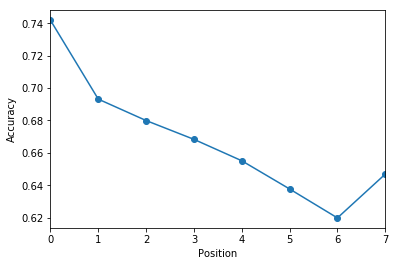

In [14]:
#N_trial = 1000 # number of trials
accs = np.zeros(N_patterns)
for _ in range(N_trial):
    Patterns, Indexs, acc, Patterns_pre, index_pre = STM_trial(ifdec=True, ifint=True, ifsat=True, ifreh=True)
    accs = accs + acc

f1 = plt.figure()
plt.plot(accs/N_trial, marker = 'o')
plt.xlim([0, N_patterns-1])
plt.ylabel("Accuracy")
plt.xlabel("Position")
plt.show(f1)

$\uparrow$ consider about the interference, decay, saturation and rehersal effect.